In [88]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from lib import *

In [89]:
@njit
def select_price_WoLF(epsilon, price_grid, current_state, policy):
    u = np.random.uniform(0,1)
    if epsilon > u:
        return np.random.choice(price_grid)
    else:
        cumsum = np.cumsum(policy[np.where(price_grid == current_state)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0]
        return price_grid[idx]
    

@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, delta, p_table, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        delta: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    maxed_Q = max(Q_table[:, s_next_index])
    new_est = profit(p_table[i, t], p_table[j, t-2]) + delta * profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

@njit
def select_price_Q(epsilon, price_grid, current_state, Q_table):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        s_t_idx = np.where(price_grid == current_state)[0][0] # current state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[s_t_idx,:])
        return price_grid[maxedQ_idx]
    

In [90]:

#@njit
def WoLF_PHC_vs_Q_learner2(alpha, delta_w, delta_l, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    # Initializing N, a counter
    N1 = np.zeros(k)
    # Initializing profits
    #p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_Q = np.random.choice(price_grid) #p_table[i,t] = np.random.choice(price_grid)
    p_WoLF = np.random.choice(price_grid) #p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    s_Q = np.random.choice(price_grid) #p_table[i,t] = np.random.choice(price_grid)
    s_WoLF = np.random.choice(price_grid) #p_table[j,t] = np.random.choice(price_grid)
    t += 1
    method = 'WoLF-PHC'
    for t in range(t, T-1):
        if method == 'WoLF-PHC':
            p_Q = s_Q
            profit_now = profit(p_Q, p_WoLF) #profit(p_table[i, t-1], p_table[j, t-1])
            profit_next = profit(p_Q, s_Q) #profit(p_table[i, t], p_table[j, t])
            r_t = profit_now + gamma * profit_next
            p_Q_idx = np.where(price_grid == p_Q)[0][0]
            s_WoLF_idx = np.where(price_grid == s_WoLF)[0][0]
            p_WoLF_idx = np.where(price_grid == p_WoLF)[0][0]
            max_Q = max(q1[s_WoLF_idx, :])
            q1[p_WoLF_idx, p_Q_idx] = q1[p_WoLF_idx, p_Q_idx] + alpha * (r_t + gamma**2 *max_Q - q1[p_WoLF_idx, p_Q_idx])
            N1[p_WoLF_idx] += 1

            avg_policy1[p_WoLF_idx, :] = avg_policy1[p_WoLF_idx, :] + (1 / N1[p_WoLF_idx]) * (policy_1[p_WoLF_idx, :] - avg_policy1[p_WoLF_idx, :])
            avg_policy1[p_WoLF_idx, :] /= avg_policy1[p_WoLF_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(q1[p_WoLF_idx, :] * policy_1[p_WoLF_idx, :]) > np.sum(q1[p_WoLF_idx, :] * avg_policy1[p_WoLF_idx, :]):
                delta = delta_w
            else:
                delta = delta_l 

            delta_sa = np.zeros(k) - delta / (k - 1)
            p_Q_max_idx = np.argmax(q1[p_WoLF_idx, :])
            delta_sa[p_Q_max_idx] = - (delta_sa.sum() - delta_sa[p_Q_max_idx])
            policy_1[p_WoLF_idx, :] += delta_sa
            policy_1[p_WoLF_idx, :] = np.minimum(1, np.maximum(policy_1[p_WoLF_idx, :], 0))
            policy_1[p_WoLF_idx, :] /= policy_1[p_WoLF_idx, :].sum() # To ensure a legal probability distribution
            s_Q = select_price_WoLF(epsilon[t], price_grid, s_WoLF, policy_1)

            profits[i, t] = profit_now #profit(p_Q, p_WoLF)
            profits[j, t] = profit(p_WoLF, p_Q)
            method = 'Q-learner'
        else:
            p_WoLF = s_WoLF
            profit_now = profit(p_WoLF, p_Q)
            profit_next = profit(p_WoLF, s_Q)
            r_t = profit_now + gamma * profit_next
            p_WoLF_idx = np.where(price_grid == p_WoLF)[0][0]
            s_Q_idx = np.where(price_grid == s_Q)[0][0]
            p_Q_idx = np.where(price_grid == p_Q)[0][0]
            s_WoLF = select_price_Q(epsilon[t], price_grid, s_Q, q2)
            s_WoLF_idx = np.where(price_grid == s_WoLF)[0][0]
            q2[p_Q_idx, p_WoLF_idx] = q2[p_Q_idx, p_WoLF_idx] + alpha * (r_t + gamma**2 * q2[s_Q_idx, s_WoLF_idx] - q2[p_Q_idx, p_WoLF_idx])

            profits[j, t] = profit_now
            profits[i, t] = profit(p_Q, p_WoLF)
            method = 'WoLF-PHC'
         # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[0, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[1, (t-1000):t])/1000
            avg_profs2.append(profitability)
        #print(p_table[0,t])
           
    return q1, q2, avg_profs1, avg_profs2, profits

            



In [91]:
q1, q2, avg_prof1, avg_prof2, profit = WoLF_PHC_vs_Q_learner2(0.3, 0.2, 0.6, 0.95, np.linspace(0,1,7), 500000)

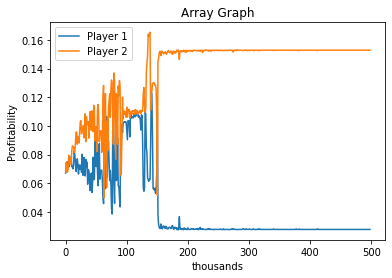

In [92]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avg_prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [93]:
np.random.seed(2020)
T = 500000 # Iterations
gamma = 0.95 # Discount factor
alpha = 0.3 # Learning rate
theta = 0.0000275 # Parameter for exploration
delta_l = 0.6 # learning rate when losing
delta_w = 0.2 # l1earning rate when winning
k = 6 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
# epsilon = np.zeros(T + 2) + 0.05
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@njit
def select_action_egreedy(Q, current_s, a, epsilon, u):
    """Epsilon-greedy action selection.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """

    if u < epsilon:
        return np.random.choice(a)
    else:
        max_idx = np.argmax(Q[np.where(a == current_s)[0][0], :])
        return a[max_idx]

@njit
def select_action_egreedy_WoLF(Q, current_s, a, epsilon, u, policy):
    """Epsilon-greedy action selection for WoLF-PHC.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
        policy: current stochastic policy according to policy hill climbing
    Returns:
        the selected action
    """
    if u < epsilon:
        return np.random.choice(a)
    else:
        cumsum = np.cumsum(policy[np.where(a == current_s)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0] 
        return a[idx]


@njit
def sequential_WoLF_PHC_learning(s, gamma, expl_param, alpha, u):
    """Function for implementing (sequential) WoLF-PHC in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))
    
    # Initialize stochastic policies as uniform distributions
    policy_1 = np.ones((len(s), len(s))) / len(s)

    # Estimates of expected value of the average policy for firm 1 and 2 respectively
    avg_policy_1 = np.ones((len(s), len(s))) / len(s)

    # Counter for every time state s is visited
    N_1 = np.zeros(len(s))
    N_2 = np.zeros(len(s))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            max_Q = max(Q_1[p_2_prime_idx, :])
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_1[p_2_idx, a_idx])
            # Step closer to optimal policy wrt. Q
            N_1[p_2_idx] += 1
            avg_policy_1[p_2_idx, :] = avg_policy_1[p_2_idx, :] + (1 / N_1[p_2_idx]) * (policy_1[p_2_idx, :] - avg_policy_1[p_2_idx, :])
            avg_policy_1[p_2_idx, :] /= avg_policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(Q_1[p_2_idx, :] * policy_1[p_2_idx, :]) > np.sum(Q_1[p_2_idx, :] * avg_policy_1[p_2_idx, :]):
                delta = delta_w
            else:
                delta = delta_l
            # delta_sa = - np.minimum(policy_1[p_2_idx, :], delta / (len(s) - 1))
            delta_sa = np.zeros(len(s)) - delta / (len(s) - 1)
            a_max_idx = np.argmax(Q_1[p_2_idx, :])
            delta_sa[a_max_idx] = - (delta_sa.sum() - delta_sa[a_max_idx])
            policy_1[p_2_idx, :] += delta_sa
            policy_1[p_2_idx, :] = np.minimum(1, np.maximum(policy_1[p_2_idx, :], 0))
            policy_1[p_2_idx, :] /= policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            p_1_prime = select_price_WoLF(expl_param[t], s, p_2_prime, policy_1)
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            p_2_prime = select_price_Q(expl_param[t], s, p_1_prime, Q_2)
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + gamma**2 * Q_2[p_1_prime_idx, p_2_prime_idx] - Q_2[p_1_idx, a_idx])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2



In [94]:
epsilon = calculate_epsilon(T)
price_grid = np.linspace(0, 1, 7)
u = np.random.uniform(size=(T + 2))
q1,q2,avg_prof1,avg_prof2, prof1, prof2 = sequential_WoLF_PHC_learning(s, gamma, epsilon, alpha, u)

ValueError: Failed in nopython mode pipeline (step: inline inlinable functions)
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

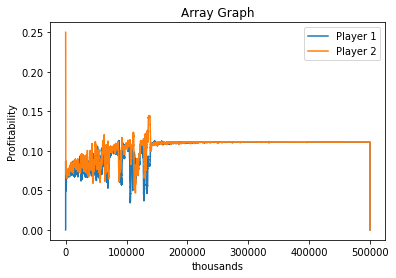

In [ ]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avg_prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()